# Multi-Layer Network Test
In this file, we explored the effects of adding another convolutional layer to our network. However, we were unable to get the 2-layer model to achieve an accuracy higher than our 1-layer model so we chose to omit it from our final results

# Imports

In [1]:
import gdown
import pandas as pd

!pip install torchviz
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import VisionDataset
import torchvision.transforms as transforms
import torch.optim as optim
import cv2
from PIL import Image

from glob import glob
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 51kB 8.2MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=e5951f02e40dc097d423584d9548c2e7850d7f0353605012d844d89cb2719f88
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


# Load Data

In [2]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1U1JpP4fH1NgsminyKKF9BDdKUumdGhB1&export=download',
             'ImageKey.csv', False)
gdown.download('https://drive.google.com/uc?authuser=0&id=1Ln4QzD_ZLSxjo-5SNpQEmI8WgcN9J9VK&export=download',
             'EvaluationKey.csv', False)


image_key = pd.read_csv('ImageKey.csv')
evaluation_key = pd.read_csv('EvaluationKey.csv')

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1U1JpP4fH1NgsminyKKF9BDdKUumdGhB1&export=download
To: /content/ImageKey.csv
5.35MB [00:00, 211MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=1Ln4QzD_ZLSxjo-5SNpQEmI8WgcN9J9VK&export=download
To: /content/EvaluationKey.csv
100%|██████████| 224k/224k [00:00<00:00, 50.9MB/s]


# Image Loading

In [3]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1Z_rAAy-3UCK3yy-c9_Mxnx7Z34oxGwNL&export=download', 'lego-vs-generic-brick-image-recognition.zip', False)

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1Z_rAAy-3UCK3yy-c9_Mxnx7Z34oxGwNL&export=download
To: /content/lego-vs-generic-brick-image-recognition.zip
1.65GB [00:16, 101MB/s] 


'lego-vs-generic-brick-image-recognition.zip'

In [0]:
# Unzip datasets - working
!unzip -qq -o lego-vs-generic-brick-image-recognition.zip

In [0]:
# Unzip photo dirs
!unzip -qq -o Base\ Images.zip
!unzip -qq -o Cropped\ Images.zip

In [6]:
!cd Cropped\ Images && ls

'Additional 1x1 Captures'   Bricks  'Evaluation Set'   Legos


## Torch Dataset (Formatting images)

In [0]:
def getFileName(filepath):
  idx = filepath.rfind("/")
  return filepath[idx+1:]

def show_image(img_tensor):
#   # Takes in PIL Image
#   I = imread(img)
#   plt.imshow(I)
#   plt.axis('off')
#   plt.show()

  # need to reorder the tensor dimensions to work properly with imshow
  plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
  plt.axis('off')
  plt.show()

class LegoData(VisionDataset):
  """
  Dataset class for the lego data
  
  Args:
    img_path (string): Filepath for images (ex: Base Images/Legos/*.jpg)
    key_df (pandas DataFrame): Dataframe containing columns Folder1	Folder2	
                               Picture Group	Timestamp	Image	Background 
                               Capture	Brand	Brick
  """
  def __init__(self, filepaths, key_df, transform=None, target_transform=None):
      super(LegoData, self).__init__('.',
                                     transform=transform,
                                     target_transform=target_transform)

      self.filepaths = filepaths
      self.key_df = key_df
      self.transform = transform
      self.target_transform = target_transform
      
      self.classes = key_df.Brick.unique()
      self.brands = key_df.Brand.unique()

  def __getitem__(self, index):
      filepath = self.filepaths[index]
      
      img = Image.open(filepath)      
    
      # Get index of row for matching filepath
      # print("filepath", getFileName(filepath))
      key_idx = self.key_df[self.key_df['Image']==getFileName(filepath)].index.item()
      
      # Get corresponding lego class for file
      img_class = self.key_df.Brick[key_idx]

      # Get int representing lego class
      # print("img_class", img_class)
      target = int(np.where(self.classes == img_class)[0])
      # print("target", target)
      # apply transformations if they exist (this is useful for images)
      if self.transform is not None:
          img = self.transform(img)

      # apply transformations if they exist (this is useful for images)
      if self.target_transform is not None:
          target = self.target_transform(target)
      

      # ## TESTING
      # output = np.zeros(len(self.classes), dtype=np.int64)
      # output[target-1] = 1 

      # t = torch.from_numpy(output)
      return img, target

  def __len__(self):
      # print(len(self.filepaths))
      return len(self.filepaths)

In [0]:
# Get images for train and test data sets and make them LegoData datasets
transform = transforms.Compose([#transforms.CenterCrop((200,200)), # Crop center of image
                                 transforms.Resize((120,160)), # Downsample image
                                 transforms.ToTensor()])     # Make pixel values a tensor
    
raw_train_filepath_list = glob("Cropped Images/Legos/*.jpg")
filtered_train_filepath_list = [x for x in raw_train_filepath_list if not 'bg' in x] # Remove background-only images
raw_test_filepath_list = glob("Cropped Images/Evaluation Set/*.jpg")
filtered_test_filepath_list = [x for x in raw_test_filepath_list if not 'bg' in x]

train_set = LegoData(filtered_train_filepath_list, image_key, transform) # Makes a dataset from filepaths
test_set = LegoData(filtered_test_filepath_list, image_key, transform)

In [9]:
train_set.classes
train_set.brands

array(['Brick', 'Lego'], dtype=object)

In [0]:
# Set up variables of information from datasets for the CNN
im, target = train_set[0] # Use first image to get image size

img_dims = tuple(im.shape)
n_train_samples = int(len(train_set) * 0.5) # Number of images to use
n_test_samples = int(len(test_set) * 0.5)
classes = train_set.classes # Classes for different sizes of legos

train_sampler = SubsetRandomSampler(np.arange(n_train_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

## Verification

In [11]:
train_set # Dataset information

Dataset LegoData
    Number of datapoints: 8344
    Root location: .
    StandardTransform
Transform: Compose(
               Resize(size=(120, 160), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

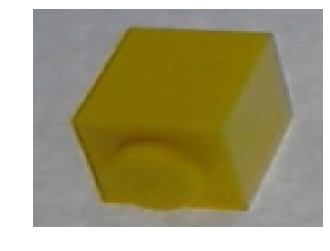

(3, 120, 160)


In [12]:
# Display a lego brick image
im, target = train_set[8300] # Can put any index here

show_image(im)
print(tuple(im.shape))

# Convolutional Neural Net

In [26]:
class_len = len(train_set.classes)

class LegoCNN2(nn.Module):
  def __init__(self):
    super(LegoCNN2, self).__init__()
    # Defines layer of CNN: convolutional -> pool -> maxpool -> fully connected reLU -> fully connected classes
    num_kernels = 16 # TODO: Why 16?
    self.conv1 = nn.Conv2d(img_dims[0], num_kernels, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, stride=2, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.pool5 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0)
    self.maxpool_output_size = int(num_kernels*2 * (img_dims[1] / (40)) * (img_dims[2]/(40))) # Denominator = Multiply strides from each layer

    # fc = fully connected (first fully connected layer)
    fc1_size = 64 # TODO Why 64 here?
    self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)
    self.activation_func = torch.nn.ReLU() # bc math...
    # Convert fc to outputs that line up with number of classes
    fc2_size = len(classes)
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.dropout = nn.Dropout(0.5) 

    # Defines operations and returns output of model
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.activation_func(x)
    x = self.conv2(x)
    x = self.pool5(x)
    x = self.activation_func(x)

    # Flattens output of conv, max pool, activation sequence
    x = x.view(-1, self.maxpool_output_size)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.activation_func(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

  def get_loss(self, learning_rate):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    return loss, optimizer

LegoCNN2()

LegoCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=384, out_features=64, bias=True)
  (activation_func): ReLU()
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [27]:
# device = 'cuda' # 'cpu' if we want to not use the gpu
device='cuda'
# Initialize the model, loss, and optimization function
net = LegoCNN2()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

LegoCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=384, out_features=64, bias=True)
  (activation_func): ReLU()
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# Training the model and determing accuracy

In [0]:
def runTesting(train_size, test_size, net):
  print("Train size: " + str(train_size))
  print("Test size: " + str(test_size))
  # Define training parameters
  training_batch_size = train_size # Number of images to use in mini-batch to train  TODO: figure out how this affects results
  testing_batch_size = test_size # Number of images to use in mini-batch to test 
  
  learning_rate = 1e-2  # TODO: how does this change things
  n_epochs = 3 #10 # TODO: orignal was 10, maybe try making it 10 again?
  # Get our data into the mini batch size that we defined
  train_loader = torch.utils.data.DataLoader(
      train_set, batch_size=training_batch_size, sampler=train_sampler, num_workers=2)
  test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=testing_batch_size, sampler=test_sampler, num_workers=2) # TODO: Why the 128
  train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net, n_epochs, learning_rate, train_loader, test_loader)
  print("Train accuracy is", get_accuracy(net, train_loader))
  print("Test accuracy is", get_accuracy(net, test_loader))
  return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [0]:
# TODO: understand and comment this plz

def train_model(net, n_epochs, learning_rate, train_loader, test_loader):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        # print("here1")
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):
            # print(i)
            # print("here2")
             # Get inputs in right form
            inputs, labels = data
            labels = torch.LongTensor(labels)
            # print(data)
            # print(type(inputs))
            # print(type(labels))
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()
            # print("here3")
            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)#np.array(labels, dtype=int))
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:
            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [0]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total

In [33]:
size1 = 16
size2 = 16

# device = 'cuda' # 'cpu' if we want to not use the gpu
device='cuda'
# Initialize the model, loss, and optimization function
# net = LegoCNN()
net = LegoCNN2()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
training_batch_size = size1
testing_batch_size = size2
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = runTesting(size1, size2, net)

Train size: 16
Test size: 16
Epoch 1, Iteration 20	 train_loss: 1.80 took: 1.71s
Epoch 1, Iteration 40	 train_loss: 1.79 took: 1.64s
Epoch 1, Iteration 60	 train_loss: 1.79 took: 1.61s
Epoch 1, Iteration 80	 train_loss: 1.79 took: 1.51s
Epoch 1, Iteration 100	 train_loss: 1.78 took: 1.59s
Epoch 1, Iteration 120	 train_loss: 1.78 took: 1.64s
Epoch 1, Iteration 140	 train_loss: 1.77 took: 1.60s
Epoch 1, Iteration 160	 train_loss: 1.74 took: 1.52s
Epoch 1, Iteration 180	 train_loss: 1.73 took: 1.55s
Epoch 1, Iteration 200	 train_loss: 1.70 took: 1.59s
Epoch 1, Iteration 220	 train_loss: 1.69 took: 1.58s
Epoch 1, Iteration 240	 train_loss: 1.65 took: 1.57s
Epoch 1, Iteration 260	 train_loss: 1.68 took: 1.52s
Validation loss = 1.71
Epoch 2, Iteration 20	 train_loss: 1.70 took: 1.73s
Epoch 2, Iteration 40	 train_loss: 1.64 took: 1.53s
Epoch 2, Iteration 60	 train_loss: 1.65 took: 1.59s
Epoch 2, Iteration 80	 train_loss: 1.64 took: 1.58s
Epoch 2, Iteration 100	 train_loss: 1.65 took: 1.59s
Ep

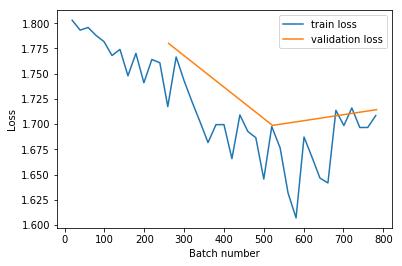

In [32]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()